In [1]:
#Set up
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report

# This is simply an alias for convenience
layers = tf.keras.layers

In [2]:
print(dir(h5py))

['AttributeManager', 'Dataset', 'Datatype', 'Empty', 'ExternalLink', 'File', 'Group', 'HLObject', 'HardLink', 'Reference', 'RegionReference', 'SoftLink', 'VirtualLayout', 'VirtualSource', '_ModuleWrapper', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_conv', '_errors', '_hl', '_objects', '_proxy', '_register_converters', '_register_lzf', '_warn', 'absolute_import', 'check_dtype', 'check_enum_dtype', 'check_ref_dtype', 'check_string_dtype', 'check_vlen_dtype', 'defs', 'enable_ipython_completer', 'enum_dtype', 'filters', 'get_config', 'get_enum', 'get_vlen', 'h5', 'h5a', 'h5ac', 'h5d', 'h5ds', 'h5f', 'h5fd', 'h5g', 'h5i', 'h5l', 'h5o', 'h5p', 'h5pl', 'h5py_warnings', 'h5r', 'h5s', 'h5t', 'h5z', 'highlevel', 'is_hdf5', 'new_enum', 'new_vlen', 'ref_dtype', 'regionref_dtype', 'register_driver', 'registered_drivers', 'run_tests', 'special_dtype', 'string_dtype', 'unregister_driver', 'utils', 'version', '

In [3]:
def get_attpc_class(label): #modify according to the input file
    """Gets the class name for a given label.
    
    Arguments:
        label (int): The integer target label.
        
    Returns:
        The name of the class that corresponds to the given label.
    """
    return ['proton', 'carbon', 'other'][label] #proton, carbon, other

def load_attpc_data():
    """Loads in the AT-TPC data.
        
    Returns:
        A tuple of the form ((real_features, real_targets), (simulated_features, simulated_targets))
    """
    simulated_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/simulated-attpc-events.h5'
    real_data_origin = '../real-attpc-events.h5'
    
    simulated_path = tf.keras.utils.get_file('simulated-attpc-data.h5', origin=simulated_data_origin)
    real_path = tf.keras.utils.get_file('real-attpc-data.h5', origin=simulated_data_origin)
    f = h5py.File(real_path, 'r')
        
    with f as h5:
        real_features = h5['features'][:]
        real_targets = h5['targets'][:]
        
    with h5py.File(simulated_path, 'r') as h5:
        simulated_features = h5['features'][:]
        simulated_targets = h5['targets'][:]
    
    return (real_features, real_targets), (simulated_features, simulated_targets)

def plot_learning_curve(history):
    """Plots a learning curve from a training history.
    
    Arguments:
        history (dict): The training history returned by `model.fit()`.
        
    Returns:
        None.
    """
    plt.figure(figsize=(11, 6), dpi=100)
    plt.plot(history.history['loss'], 'o-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'o:', color='r', label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history.history['loss'])), range(1, len(history.history['loss']) + 1))
    plt.show()
    
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

In [4]:
(real_features, real_targets), (sim_features, sim_targets) = load_attpc_data()

In [5]:
print('Real Features:\n   Shape: {}\n   Type: {}\n'.format(real_features.shape, real_features.dtype))
print('Real Targets:\n   Shape: {}\n   Type: {}\n'.format(real_targets.shape, real_targets.dtype))
print('Simulated Features:\n   Shape: {}\n   Type: {}\n'.format(sim_features.shape, sim_features.dtype))
print('Simulated Targets:\n   Shape: {}\n   Type: {}'.format(sim_targets.shape, sim_targets.dtype))

Real Features:
   Shape: (2689, 128, 128)
   Type: uint8

Real Targets:
   Shape: (2689,)
   Type: uint8

Simulated Features:
   Shape: (50000, 128, 128)
   Type: uint8

Simulated Targets:
   Shape: (50000,)
   Type: uint8


In [6]:
sim_features = sim_features[:10000]
sim_targets = sim_targets[:10000]

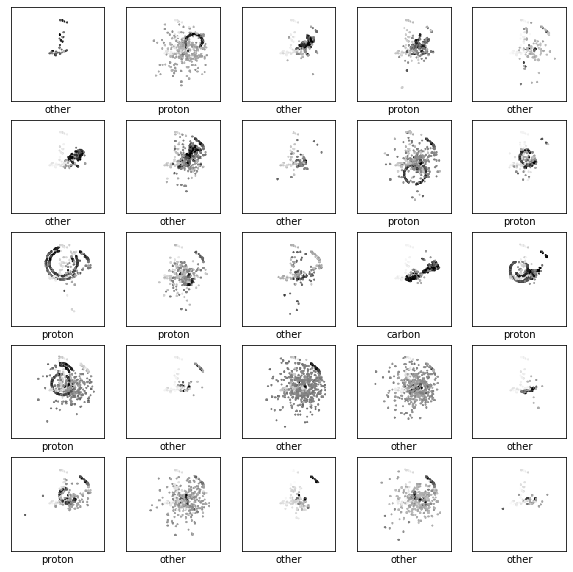

In [7]:
#Experimental data 
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(real_features[i], cmap='gray')
    plt.xlabel(get_attpc_class(real_targets[i])) #can change labels for different experiments/reactions
    
plt.show()


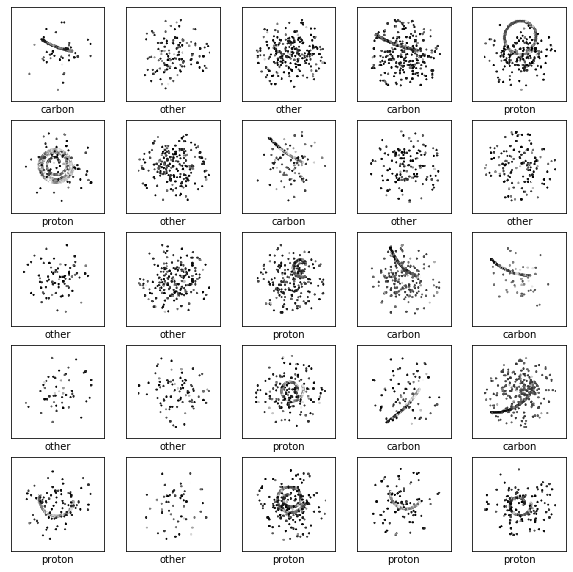

In [8]:
#Simulated data
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sim_features[i], cmap='gray')
    plt.xlabel(get_attpc_class(sim_targets[i]))
    
plt.show()

In [9]:
# NORMALIZE THE DATA
real_features = (real_features - 127.5) / 127.5
sim_features = (sim_features - 127.5) / 127.5

# ADD A CHANNEL DIMENSION
real_features = np.expand_dims(real_features, axis=3)
sim_features = np.expand_dims(sim_features, axis=3)

# Some checks to make sure the data has been correctly preprocessed
assert real_features.shape[1:] == (128, 128, 1), 'Real data has incorrect shape'
assert sim_features.shape[1:] == (128, 128, 1), 'Simulated data has incorrect shape'
assert real_features.min() >= -1 and real_features.max() <= 1, 'Real data is not in the range [-1, 1]'
assert sim_features.min() >= -1 and sim_features.max() <= 1, 'Simulated data is not in the range [-1, 1]'

In [10]:
real_features = np.repeat(real_features, 3, axis=3)
sim_features = np.repeat(sim_features, 3, axis=3)

input_shape = real_features.shape[1:]
print('Image dimensions: {}'.format(input_shape))

Image dimensions: (128, 128, 3)


In [11]:
# Determine the number of class labels
num_classes = len(np.unique(real_targets))

def build_pretrained_vgg_model():
    """Constructs a CNN with a VGG16's convolutional base and two fully-connected hidden layers on top.
    The convolutional base is frozen (the weights can't be updated) and has weights from training on
    the ImageNet dataset.
    
    Returns:
        The model.
    """
    # This loads the VGG16 model from TensorFlow with ImageNet weights
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # First we flatten out the features from the VGG16 model
    net = layers.Flatten()(vgg_model.output)

    # We create a new fully-connected layer that takes the flattened features as its input
    net = layers.Dense(512, activation=tf.nn.relu)(net)
    # And we add one more hidden layer
    net = layers.Dense(512, activation=tf.nn.relu)(net)

    # Then we add a final layer which is connected to the previous layer and
    # groups our images into one of the three classes
    output = layers.Dense(num_classes, activation=tf.nn.softmax)(net)

    # Finally, we create a new model whose input is that of the VGG16 model and whose output
    # is the final new layer we just created
    model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
    
    # We loop through all layers except the last four and specify that we do not want 
    # their weights to be updated during training. Again, the weights of the convolutional
    # layers have already been trained for general-purpose feature extraction, and we only
    # want to update the fully-connected layers that we just added.
    for layer in model.layers[:-4]:
        layer.trainable = False
        
    return model

In [14]:
model = build_pretrained_vgg_model()

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #try woth lower learning rate and changed tf.optimizers.Adam() 

In [15]:
model.fit(sim_features[:5000],
          sim_targets[:5000],
          batch_size=32,
          epochs=3,
          validation_split=0.2);

Epoch 1/3
125/125 [==============================] - 201s 2s/step - loss: 1.3880 - accuracy: 0.7442 - val_loss: 0.3135 - val_accuracy: 0.8730
Epoch 2/3
125/125 [==============================] - 198s 2s/step - loss: 0.3161 - accuracy: 0.8723 - val_loss: 0.2896 - val_accuracy: 0.8870
Epoch 3/3
125/125 [==============================] - 203s 2s/step - loss: 0.2570 - accuracy: 0.9030 - val_loss: 0.2658 - val_accuracy: 0.8980


In [16]:
# This is the directory where model weights will be saved. Feel free to change it.
CHECKPOINT_DIR = './model-checkpoints/'

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# The checkpoints will be saved with the corresponding epoch number in their filename
ckpt_path = os.path.join(CHECKPOINT_DIR, 'weights.epoch.{epoch:02d}')

# Setup checkpoint callback. We only save the weights, not the entire model
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True)

In [17]:
# Reset the model again
model = build_pretrained_vgg_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# The `fit` method returns a dictionary containing metrics from the training.
# We will use that information later.
history = model.fit(sim_features[:5000],
                    sim_targets[:5000],
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[ckpt_callback])


Epoch 1/10
125/125 [==============================] - 196s 2s/step - loss: 0.5763 - accuracy: 0.7670 - val_loss: 0.2868 - val_accuracy: 0.8890
Epoch 2/10
125/125 [==============================] - 196s 2s/step - loss: 0.2945 - accuracy: 0.8838 - val_loss: 0.2811 - val_accuracy: 0.8930
Epoch 3/10
125/125 [==============================] - 198s 2s/step - loss: 0.2729 - accuracy: 0.8890 - val_loss: 0.3664 - val_accuracy: 0.8310
Epoch 4/10
125/125 [==============================] - 230s 2s/step - loss: 0.2296 - accuracy: 0.9062 - val_loss: 0.2269 - val_accuracy: 0.9080
Epoch 5/10
125/125 [==============================] - 214s 2s/step - loss: 0.2004 - accuracy: 0.9210 - val_loss: 0.2252 - val_accuracy: 0.9130
Epoch 6/10
125/125 [==============================] - 223s 2s/step - loss: 0.1969 - accuracy: 0.9205 - val_loss: 0.2205 - val_accuracy: 0.9130
Epoch 7/10
125/125 [==============================] - 226s 2s/step - loss: 0.1950 - accuracy: 0.9273 - val_loss: 0.2134 - val_accuracy: 0.9110

In [19]:
EARLY_STOPPING_EPOCH = 3

assert EARLY_STOPPING_EPOCH > 0, 'You need to set an early stopping point!'

# Path the the checkpoint we want to load
es_ckpt_path = os.path.join(CHECKPOINT_DIR, 'weights.epoch.{:02d}'.format(EARLY_STOPPING_EPOCH))

# Load the weights from the desired checkpoint into the model
model.load_weights(es_ckpt_path);

In [20]:
test_loss, test_accuracy = model.evaluate(real_features, real_targets, verbose=0)

print('Test accuracy: {:.04}'.format(test_accuracy))

Test accuracy: 0.3035


In [21]:
# The model gives us a matrix with each example's softmax probabilities for each class
predicted_probabilities = model.predict(real_features)
# We reduce that to a single predicted class for each example by taking the
# class with the largest probability
predictions = np.argmax(predicted_probabilities, axis=1)

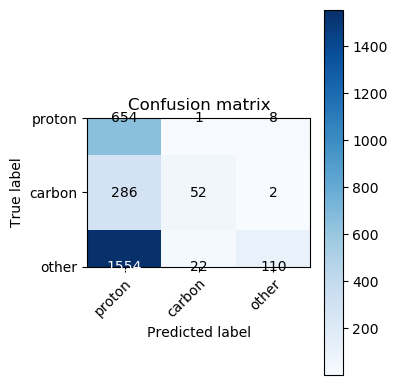

In [22]:
# Get the names of each of the classes
class_names = [get_attpc_class(i) for i in range(num_classes)]

# This function (defined at the top) will plot the confution matrix.
# We give it the predictions and the real labels. The function relies
# on scikit-learn's convenient confusion matrix function.
plot_confusion_matrix(real_targets, predictions, class_names)

In [25]:
# ADDED CALL TO CLASSIFICATION_REPORT HERE
target_names = ['proton', 'carbon', 'other']
print(classification_report(real_targets, predictions, target_names=target_names))


              precision    recall  f1-score   support

      proton       0.26      0.99      0.41       663
      carbon       0.69      0.15      0.25       340
       other       0.92      0.07      0.12      1686

    accuracy                           0.30      2689
   macro avg       0.62      0.40      0.26      2689
weighted avg       0.73      0.30      0.21      2689

